In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np

-


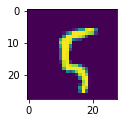

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

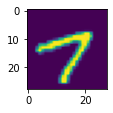

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

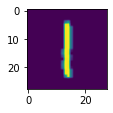

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

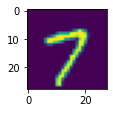

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [5]:
train_data = datasets.MNIST('./data/', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])) # 학습 데이터
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=50, shuffle=True)

test_data = datasets.MNIST('./data/', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])) # 테스트 데이터
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=50, shuffle=True)
print("-")

for i in range(4):
    img, label = train_data[i+100]
    # print(labels[label])
    plt.subplot(241 + i)
    plt.imshow(np.clip(img.permute(1,2,0),0,1))
    plt.tight_layout()
    plt.show()
# for i in img[0]:
    # print(max(i))
    print(img[0])

In [3]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def imshow(img):
    img = img /2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))
    # plt.show()


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(-1, self.num_flat_features(x)) # [batch_size, 50, 4, 4]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x): 
        size = x.size()[1:] 
        num_features = 1 
        for s in size: 
            num_features *= s 
        return num_features


In [5]:
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [6]:
cnn = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
print(torch.cuda.is_available())

cpu is available
False


In [7]:
cnn.train()  # 학습을 위함
for epoch in range(5):
  for index, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()  # 기울기 초기화
    output = cnn(data)
    print(output)
    loss = criterion(output, target)
    loss.backward()  # 역전파
    optimizer.step()

    if index % 100 == 0:
      print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))

-2.6207e+00,
         -3.2770e+00, -5.4190e+00,  5.0561e-01,  1.9894e+00, -5.7088e+00],
        [-3.9235e+00,  3.7244e+00,  3.9453e+00,  3.7989e+00, -4.4542e+00,
         -2.5559e+00, -1.1753e+01,  1.2709e+01,  5.8351e-01,  3.0284e+00],
        [-2.9542e+00,  2.5004e+00,  1.3018e+00,  2.6655e+00,  5.5042e-02,
         -1.3243e+00, -1.3437e+01,  1.3980e+01, -1.7304e+00,  4.6280e+00],
        [-1.7885e+00,  5.4757e-02, -1.6471e+00,  1.6529e-01,  3.5299e+00,
         -1.6495e+00, -9.2099e+00,  5.5734e+00, -1.2240e-01,  1.0598e+01],
        [-4.9848e+00,  1.8003e+00, -3.2969e+00,  1.1389e+01, -3.3893e+00,
          3.8534e+00, -7.0126e+00, -2.0773e+00,  4.1751e+00,  5.0153e+00],
        [-8.1090e+00, -5.6318e+00, -1.2951e+01,  5.5913e+00, -2.8269e+00,
          2.4884e+01, -3.5362e+00, -2.5872e+00,  2.0070e+00,  9.5413e+00],
        [-1.9572e+00, -4.5801e+00, -1.6696e+00,  2.7078e+00, -4.8447e+00,
          1.3432e+01,  2.4583e+00, -5.8622e+00,  1.3774e+00, -1.6811e+00],
        [ 1.3094e+

In [8]:
cnn.eval()  # test case 학습 방지를 위함
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    output = cnn(data)
    test_loss += criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0389, Accuracy: 9877/10000 (99%)



In [ ]:

        # print(data.shape)
        # edge_arr = []
        # for ed in edge_data:
            # _, encoded_img = cv.imencode(".jpg", np.transpose(ed, (1,2,0)))
            # ed = ed.detach().numpy().astype(np.uint8)
            # edge_img = cv.Canny(np.transpose(ed, (1,2,0)), 30, 50)
        #     edge_img = cv.cvtColor(edge_img,cv.COLOR_GRAY2RGB)
        #     edge_arr.append(np.transpose(edge_img, (2,0,1)))
        # edge_data = torch.from_numpy(np.asarray(edge_arr))
        # edge_data = edge_data.cuda()
        # print(edge_data.shape)